# Dashboard

## 1 - Libaries Import

In [9]:
%reset -f

# Import Os to get to the root directory
import os
import sys

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

TEST_DIR = os.path.join(ROOT_DIR, "test-white-papers")
MODEL_DIR = os.path.join(ROOT_DIR, "model")

# First, we define the path where our Train dataset is located
TRAIN_DIR = os.path.join(ROOT_DIR, "dataset")
TRAIN_CSV = os.path.join(TRAIN_DIR, "train.csv")
        
# Import own functions
from libraries import corpus
from libraries import pdf2text

##########################
# Import other libraries
##########################

# Data Processing
import numpy as np
import pandas as pd
import re
import io
import json

import warnings
warnings.filterwarnings("ignore")

In [24]:
# Natural Language Processing libraries
import nltk
from nltk import bigrams, ngrams
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.probability import FreqDist

# Visualizations
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib.ticker import FuncFormatter

# Machine Learning Libraries
from sklearn.cluster import AffinityPropagation,KMeans
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Neural Network Libraries
#from keras.models import load_model
#from keras.preprocessing import text

# Word Vectors and Topic Modeling Library
import gensim
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.utils import lemmatize, simple_preprocess
from gensim.models.ldamodel import LdaModel
from gensim import corpora

# Natural Language Processing Library
import spacy

# Others
from collections import Counter
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# 2 - Methods Application

In [12]:
class Data:
    def __init__(self):
        # Retrieving the PDF files from white-paper folder and converting them to text
        self.dataset = pdf2text.get_dataset()
        
        # Define if you want your corpus to be whole or divided in sentences
        makeSentences = True
        # Creates a dictionary with each White Paper and its text pre-processed
        self.corpora_sent = corpus.makeCleanCorpus(self.dataset, lemmatize=True, removePunct=True, removeNums=True
                            ,makeSentences=makeSentences, removeURL=True, removeChar=True, removeEnt=True)
        
        # Define if you want your corpus to be whole or divided in sentences
        makeSentences = False
        # Creates a dictionary with each White Paper and its text pre-processed
        self.corpora_whole = corpus.makeCleanCorpus(self.dataset, lemmatize=True, removePunct=True, removeNums=True
                            ,makeSentences=makeSentences, removeURL=True, removeChar=True, removeEnt=True)
    
        # Retrieve the NEW White Papers to Test
        self.testset = pdf2text.get_dataset(path=TEST_DIR)
        
        # Define if you want your corpus to be whole or divided in sentences
        makeSentences = True
        # Creates a dictionary with each White Paper and its text pre-processed
        self.corpora_test_sent = corpus.makeCleanCorpus(self.testset, lemmatize=True, removePunct=True, removeNums=True
                                ,makeSentences=makeSentences, removeURL=True, removeChar=True, removeEnt=True)
        
        # Define if you want your corpus to be whole or divided in sentences
        makeSentences = False
        
        # Creates a dictionary with each White Paper and its text pre-processed
        self.corpora_test_whole = corpus.makeCleanCorpus(self.testset, lemmatize=True, removePunct=True, removeNums=True
                                 ,makeSentences=makeSentences, removeURL=True, removeChar=True, removeEnt=True)

In [18]:
class InformationRetrieval():
    
    def __init__(self, data):
        self.data = data
        
    # Define function
    def prepare_data(self, corpus, protocol):
        """
        Function that receives a name of a protocol and return the tokens.
        Input:
            Name of protocol
        Output:
            Tokens
        """
        assert protocol in corpus.keys()

        # Start tokenizing the dataset
        tokenizer = nltk.tokenize.RegexpTokenizer('\s+', gaps=True)

        tokens = tokenizer.tokenize(corpus[protocol])

        return tokens
    
    
    def visualize_ngrams(self,tokens, n = 2):
    
        assert n > 1

        if n == 2:
            bigrams_tokens = bigrams(tokens)
            fdist_bigrams = FreqDist(list(bigrams_tokens))
            plt = fdist_bigrams.plot(30,cumulative=False,title="Most common N-Grams")
            return plt
        if n == 3:
            trigrams_tokens = ngrams(tokens, 3)
            fdist_trigrams = FreqDist(list(trigrams_tokens))
            plt = fdist_trigrams.plot(30,cumulative=False,title="Most common N-Grams")
            return plt
        if n > 3:
            grams_tokens = ngrams(tokens, n)
            fdist_grams = FreqDist(list(grams_tokens))
            plt = fdist_grams.plot(30,cumulative=False,title="Most common N-Grams")
            return plt
            
    
    def visualize_word_cloud(self,corpus,protocol):
        text = corpus[protocol]
        wordcloud = WordCloud(background_color="white",
                              stopwords = set(STOPWORDS)
                              ).generate(text)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title("Word Cloud")
        
        return plt

In [13]:
class DocumentClustering():
    
    def __init__(self, data):
        self.data = data
        
    def prepare_data(self):
        # Function that converts a dictionary into a Pandas Dataframe
        # The indexes are the name of the files
        self.df = corpus.dictionaryToPandas(self.data.corpora_whole)

        # Instantiate TfidfVectorizer object with stopwords and tokenizer
        # parameters for efficient processing of text
        tfidf_vectorizer = TfidfVectorizer(max_features=20000,
                                                stop_words='english', lowercase = True,
                                                 use_idf=True, tokenizer=self.tokenize_and_stem,
                                                 ngram_range=(1,3))

        # Fit and transform the tfidf_vectorizer with the "text" of each paper
        # to create a vector representation of the plot summaries
        tfidf_matrix = tfidf_vectorizer.fit_transform(self.data.corpora_whole.values())

        self.matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names(),index=self.data.corpora_whole.keys())

    # Define a function to perform both stemming and tokenization
    def tokenize_and_stem(self,text):

        # Tokenize by sentence, then by word
        tokens = [word for text in nltk.sent_tokenize(text) for word in nltk.word_tokenize(text)]

        # Filter out raw tokens to remove noise
        filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]

        return filtered_tokens
    
    # Defining Function
    def clustering_on_wordvecs(self,word_vectors, num_clusters):
        """
        Function that receives a word vectors and a number of clusters, and return the centers and the clusters

        """
        
        # Initalize a k-means object and use it to extract centroids
        kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
        
        idx = kmeans_clustering.fit_predict(word_vectors);

        return kmeans_clustering.cluster_centers_, idx;

    #Average out vectors in a document
    def average_word_vectors(self,words, model, vocabulary, num_features):
        """
        Function that receives a words, a model, a vocabulary and number of features and return averages

        """
        feature_vector = np.zeros((num_features,),dtype="float64")
        nwords = 0.

        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model[word])

        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    #Process a single document 
    def averaged_word_vectorizer(self,corpus, model, num_features):
        vocabulary = set(model.wv.index2word)
        features = [self.average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                        for tokenized_sentence in corpus]
        
        return np.array(features)

    
    def clean_text(self,all_documents):
        rslt = []
        tokenizer = nltk.data.load('tokenizers/punkt/english.pickle');
        for pos in range(len(all_documents)):
            doc_rslt = []
            # Get the comment
            doc = all_documents[pos];

            # Normalize tabs and remove newlines
            no_tabs = str(doc).replace('\t', ' ').replace('\n', '');

            # Remove all characters except A-Z and a dot.
            alphas_only = re.sub("[^a-zA-Z\.]", " ", no_tabs);

            # Normalize spaces to 1
            multi_spaces = re.sub(" +", " ", alphas_only);

            # Strip trailing and leading spaces
            no_spaces = multi_spaces.strip();

            # Normalize all charachters to lowercase
            clean_text = no_spaces.lower();

            # Get sentences from the tokenizer, remove the dot in each.
            sentences = tokenizer.tokenize(clean_text);
            sentences = [re.sub("[\.]", "", sentence) for sentence in sentences];

            # If the text has more than one space (removing single word comments) and one character, write it to the file.
            if len(clean_text) > 0 and clean_text.count(' ') > 0:
                for sentence in sentences:
                    for word in sentence.split(" "):
                        doc_rslt.append(word)

            rslt.append(doc_rslt)

        return rslt

    def get_word2vec_model(self):
        
        # Load the model
        self.model = word2vec.Word2Vec.load("model_word2vec_clustering.model")

    def get_ap_model(self):
        
        #COnverting into list of words
        cleaned_text = self.clean_text(list(self.data.corpora_whole.values()))

        w2v_feature_array = self.averaged_word_vectorizer(corpus=cleaned_text, model=self.model,
                                                     num_features=100)
        # Create an
        self.ap = AffinityPropagation()

        self.ap.fit(w2v_feature_array)

        ap_centers = self.ap.cluster_centers_

        cluster_labels = self.ap.labels_
        cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])

        self.df = self.df.reset_index()
        rslt_df = pd.concat([self.df, cluster_labels], axis=1)

        clus_val = rslt_df.ClusterLabel.value_counts()

        # Create a Dataframe with the predicted clusters
        self.reference = rslt_df[["index","ClusterLabel"]]

        self.reference.columns = ["protocol","ap_cluster"]


    def visualize_ap_clusters(self,protocol):
        # Application of Affinity Propagation Cluster to a specific white paper
        cleaned_text = self.clean_text(list([self.data.corpora_test_whole[protocol]]))

        w2v_feature_array = self.averaged_word_vectorizer(corpus=cleaned_text, model=self.model,
                                                     num_features=100)

        predict = self.ap.predict(w2v_feature_array)

        # List of other protocols in the same cluster
        similars = self.reference[self.reference.ap_cluster == predict[0]].protocol
        
        stats = corpus.get_datastats()

        result = pd.merge(similars.to_frame(),stats, left_on="protocol",right_on="name",how="inner")

        result = result.sort_values(by="rank")

        plt.plot(result.protocol, result["rank"])
        plt.title("Similar Protocol + Ranks")
        plt.xticks(rotation=90)
        plt.xlabel("Protocols in Cluster")
        plt.ylabel("Rank")
        
        return plt


In [ ]:
class TextExtraction():
    
    def __init__(self, data):
        self.data = data
        
    def prepare_data(self):
        
        # Prepare the array with the tokens
        self.tokens = []

        # Iterate through all the papers and get all the different words within the papers
        for k in self.data.corpora_whole.keys():
            self.tokens.append(word_tokenize(self.data.corpora_whole[k]))
    
    def get_word2vec_model(self):
        
        self.model = Word2Vec.load("model_word2vec_textextraction.model")
    
    # Define Function
    def visualize_ent(self,protocol):
        """
        Function that receives the name of a paper, and retrieves a plot with the most common entities found
        Input:
            Name of a white paper in the corpus
        Output:
            Plot
        """

        assert protocol in self.data.testset.keys()

        # Load the NLP object with pre-trained data
        nlp = spacy.load('en_core_web_md')

        # Create an object of the paper chosen
        doc1 = nlp(self.data.testset[protocol])

        # Get all the entities gather from the documents
        items1 = [x.label_ for x in doc1.ents]

        # Get the most common entities found in the paper
        i1 = Counter(items1).most_common(10)

        # Pepare the arrays for the plot
        x1 = []
        y1 = []

        # Iterate through the entities and add them into the array
        for i in range(len(i1)):
            x1.append(i1[i][0])
            y1.append(i1[i][1])

        # Create the visualization
        plt.plot(x1, y1)
        plt.title("Type of Entities in Protocol")
        plt.xticks(rotation=90)
        plt.xlabel("Entity Types")
        plt.ylabel("Quantity")
        
        return plt
    
    # Define the function
    def visualize_wordvec(self,topic, protocol):
        """
        Function that receives a word and the name of a paper, and returns a visualization with similar words
        Input:
            Specific topic
            Name of the protocol
            Corpora with all the texts
            Word2Vec Model with all the Vectors
        Output:
            Plots
        """
        assert protocol in self.data.corpora_test_whole.keys()

        # Create an empty Word2Vec object where we will put the weights for the specific protocol, based on the whole corpus
        model_test = Word2Vec()

        # Prepare the array with the tokens
        tokens = []

        # Tokenize white paper
        tokens.append(word_tokenize(self.data.corpora_test_whole[protocol]))

        # Iterate through all the words in the specific white paper, and add the weights into the new model
        for word in tokens[0]:
            if word in self.model.wv.vocab:
                model_test.wv[word] = self.model.wv[word]

        # Get most similar word, based on the whole corpus
        l = model_test.wv.most_similar([topic])

        # Prepare the arrays for the visualizations
        x = []
        y = []

        # Iterate through the similar words
        for i in range(len(l)):
            x.append(l[i][0])
            y.append(l[i][1])

        # Prepare Visualization 
        plt.plot(x, y)
        plt.xticks(rotation=90)
        plt.title("Words similarity within White Paper")
        plt.xlabel("Words")
        plt.ylabel("% Similarity")
        
        return plt
        
    def visualize_pca(self,protocol):
        assert protocol in self.data.corpora_test_whole.keys()


        # Prepare the array with the tokens
        tokens = []

        # Iterate through all the papers and get all the different words within the papers
        for k in self.data.corpora_test_whole.keys():
            tokens.append(word_tokenize(self.data.corpora_test_whole[k]))

        # Iterate through the the protocols to get the position of the protocol
        n = 0    
        for i in enumerate(self.data.corpora_test_whole.items()):
            if i[1][0] == protocol:
                n = i[0]
            else: continue
                
                
        # Model with only words in the exact protocol
        model2 = Word2Vec(tokens[n], size =100, window=5, min_count=1, workers=2)

        # Get the similar words within the exact protocol
        X = model2[model2.wv.vocab]
        pca = PCA(n_components=2)
        result = pca.fit_transform(X)

        # Prepare Visualization
        plt.scatter(result[:,0], result[:,1], s=100)
        words = list(model2.wv.vocab)

        for i, word in enumerate(tokens[n][:]):
            try:
                plt.annotate(word, xy=(result[i,0], result[i,1]), size = 10)
            except:
                pass
        
        plt.title("PCA on Words of White Paper")
        plt.xlabel("PCA1")
        plt.ylabel("PCA2")
        return plt

In [14]:
class TopicModeling():
    def __init__(self, data):
        self.data = data
    
    def prepare_data(self):        
        #Combining them and putting into pandas dataframe
        combined = {key:[self.combine_text(value)] for (key, value) in self.data.corpora_sent.items()}
        test_combined = {key:[self.combine_text(value)] for (key, value) in self.data.corpora_test_sent.items()}
        
        self.test_df = pd.DataFrame.from_dict(test_combined).transpose()
        self.test_df.columns = ['whitepapers']
        self.test_df = self.test_df.sort_index()
        self.test_df.head()
        
        self.df = pd.DataFrame.from_dict(combined).transpose()
        self.df.columns = ['whitepapers']
        self.df = self.df.sort_index()
        self.df.head()
        
        #creating the list and tokenizing each word in the test corpus
        testdata = self.test_df.whitepapers.values.tolist()
        testdata_words = list(self.sent_to_words(testdata))

        self.test_data_ready = self.process_words(testdata_words)
        
        #creating the list and tokenizing each word in the test corpus
        data = self.df.whitepapers.values.tolist()
        data_words = list(self.sent_to_words(data))

        data_ready = self.process_words(data_words)

        id2word = corpora.Dictionary(data_ready)

        # Apply the Topic Model into unseen documents
        self.corpus_lda_test = [id2word.doc2bow(text) for text in self.test_data_ready]

    def combine_text(self,list_of_text):
        '''Takes a list of text and combines them into one large chunk of text.'''
        combined_text = ' '.join(list_of_text)
        return combined_text
    
    # tokenizing the entire corpus by word
    def sent_to_words(self, sentences):
        for sent in sentences:
            sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
            sent = re.sub('\s+', ' ', sent)  # remove newline chars
            sent = re.sub("\'", "", sent)  # remove single quotes
            sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
            yield(sent)  
    
    # Function that gets the Dominant Topic in a Document
    def format_topics_sentences(self):
        
        # Init output
        sent_topics_df = pd.DataFrame()

        # Get main topic in each document
        for i, row_list in enumerate(self.model[self.corpus_lda_test]):
            row = row_list[0] if self.model.per_word_topics else row_list            
            # print(row)
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
            # Get the Dominant topic, Perc Contribution and Keywords for each document
            for j, (topic_num, prop_topic) in enumerate(row):
                if j == 0:  # => dominant topic
                    wp = self.model.show_topic(topic_num)
                    topic_keywords = ", ".join([word for word, prop in wp])
                    sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                else:
                    break
        
        sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

        # Add original text to the end of the output
        contents = pd.Series(self.test_data_ready)
        sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
        
        return(sent_topics_df)

    def process_words(self, texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        # Build the bigram and trigram models
        bigram = gensim.models.Phrases(texts, min_count=5, threshold=100) # higher threshold fewer phrases.
        trigram = gensim.models.Phrases(bigram[texts], threshold=100)  
        bigram_mod = gensim.models.phrases.Phraser(bigram)
        trigram_mod = gensim.models.phrases.Phraser(trigram)

        """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
        texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
        texts = [bigram_mod[doc] for doc in texts]
        texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
        texts_out = []
        #nlp = spacy.load('en', disable=['parser', 'ner'])
        nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        # remove stopwords once more after lemmatization
        texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
        return texts_out

    # Function that gets all the topics per document
    def topics_per_document(self, protocol):
        
        index = self.test_df.reset_index().loc[self.test_df.index == protocol].index[0]
        corpus_sel = [self.corpus_lda_test[index]]
        
        dominant_topics = []
        topic_percentages = []
        
        for i, corp in enumerate(corpus_sel):
            topic_percs, wordid_topics, wordid_phivalues = self.model[corp]
            dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
            dominant_topics.append((i, dominant_topic))
            topic_percentages.append(topic_percs)
        
        return(dominant_topics, topic_percentages)


    def get_lda_model(self):
        
        self.model = LdaModel.load("model_lda_topicmodeling.model")
        
    def visualize_topics(self,protocol):
        
        unseen_doc = self.corpus_lda_test[0]
        # get topic probability distribution for a document
        vector = self.model[unseen_doc] 

        # Format the topics from the unseen data into the LDA Model
        df_topic_sents_keywords = self.format_topics_sentences()

        # Format
        df_dominant_topic = df_topic_sents_keywords.reset_index()
        df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

        # Use the function to get the percentages of topics in the document
        _, topic_percentages = self.topics_per_document(protocol=protocol)            

        # Total Topic Distribution by actual weight
        topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
        df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

        # Top 3 Keywords for each Topic
        topic_top3words = [(i, topic) for i, topics in self.model.show_topics(formatted=False) 
                                         for j, (topic, wt) in enumerate(topics) if j < 3]

        df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
        df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
        df_top3words.reset_index(level=0,inplace=True)

        # Plot
        fig, ax = plt.subplots(1, 1)

        # Topic Distribution by Topic Weights
        ax.bar(x='index', height='count', data=df_topic_weightage_by_doc)
        ax.set_xticks(range(6))
        tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
        ax.xaxis.set_major_formatter(tick_formatter)
        ax.set_title('Number of Documents by Topic Weightage')

        return plt
    

In [15]:
class TextClassification():
    
    def __init__(self, data):
        self.data = data
        
    def prepare_data(self):
        self.df_train_1 = pd.DataFrame(columns=["Text","Protocol"])

        self.df_test_1 = pd.DataFrame.from_dict(self.data.corpora_test_whole,orient="index").reset_index()

        self.df_test_1.columns = ["Protocol", "Text"]
        
        # Define a Data Frame to put all the corpora_sent into a Pandas dataframe
        self.df_test_2 = pd.DataFrame(columns=["Text","Protocol"])
        
        # Iterate over each white paper, and on each sentence, and add it to the Dataframe
        i=0
        for k, v in enumerate(self.data.corpora_test_sent):
            for sent in self.data.corpora_test_sent[v]:
                self.df_test_2.loc[i, "Text"] = sent
                self.df_test_2.loc[i, "Protocol"] = v
                i += 1
    
    def get_tokenizer(self):
        # Get the Tokenizer object
        with open('model_tokenizer_classification.json') as f:
            data = json.load(f)
            self.tokenize = text.tokenizer_from_json(data)
        
    def get_log_model(self):
        # Read the csv and load it on a DataFrame
        df = pd.read_csv(TRAIN_CSV, sep=';', encoding="utf-8-sig")
        
        # Lower all the words
        df.Label = df.Label.apply(lambda x : x.lower())

        # Define the labels and also the Train dataset
        labels = df.groupby(by='Label').count().sort_values(by='Label').reset_index()['Label']

        X_train = df["Text"]
        y_train = df["Label"]

        # We need to add another category, in case there is no topic mentioned on the sentence
        X_train[len(X_train)+1] = ""
        y_train[len(y_train)+1] = "none"

        # We train a really simple Logistic Regression
        self.logreg = Pipeline([('vect', CountVectorizer()),
                        ('tfidf', TfidfTransformer()),
                        ('clf', LogisticRegression(n_jobs=1, C=1e5)),
                       ])
        
        self.logreg.fit(X_train, y_train)
        
    def get_nn_model(self):
        
        # We load our Neural Network from previous model weights
        self.model = load_model("model_neuralnetwork_classification.h5")
        
    def visualize_log(self,protocol):
        # First, we define our test dataframe
        X_test = self.df_test_2["Text"]

        # Then, for the second model, we predict it
        predict_logreg = self.logreg.predict(X_test)

        # Add into the Dataframe
        self.df_test_2["Model_2"] = predict_logreg

        protocol_test = self.df_test_2[self.df_test_2.Protocol == protocol].groupby(by="Model_2").count().sort_values(by="Text", ascending=False)
        protocol_test['percentage'] = protocol_test['Text']/protocol_test['Text'].sum()

        protocol_test = protocol_test.drop("none", axis=0).reset_index()

        # PLOT
        plt.bar(protocol_test.Model_2, protocol_test.percentage)
        plt.title("Dimension Distributions") 
        plt.xlabel("Investor Dimensions")
        plt.ylabel("% Appearance")
        
        return plt


    def visualize_nn(self,protocol):      
        # First, we define our test dataframe
        X_test = self.df_test_1["Text"]

        # For the first model, we need to tokenize the text
        X_test = self.tokenize.texts_to_matrix(X_test)
        
        # Predict
        predict_nn = self.model.predict(X_test)

        # Add into the DataFrame
        self.df_test_1["Model_1"] = predict_nn.tolist()
        
        # Generate the Labels, with the name of each White Paper
        labels = list(self.data.corpora_sent.keys())
        
        pd.options.display.float_format = '{}'.format
        
        for index, row in self.df_test_1.iterrows():
            if row["Protocol"] == protocol:
                frame = pd.DataFrame()
                frame["weights"] = row["Model_1"]
                frame["label"] = labels
                frame = frame.sort_values(by="weights", ascending=False)
                frame = frame.head(5)
                
                # PLOT
                plt.bar(frame.label, frame.weights)
                plt.title(row["Protocol"]) 
                plt.xlabel("Train Protocols")
                plt.ylabel("% Likelihood")
        
        return plt


# 3 - Visualization

In [16]:
dataset = Data()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\laman\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\laman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading en_core_web_md: Package 'en_core_web_md' not
[nltk_data]     found in index


Cleaning: #metahash
Cleaning: 0x
Cleaning: abbccoin
Cleaning: aion
Cleaning: apollocurrency
Cleaning: ardor
Cleaning: ark
Cleaning: basicattentiontoken
Cleaning: bhpcoin
Cleaning: binancecoin
Cleaning: bitcoin
Cleaning: bitcoingold
Cleaning: bitshares
Cleaning: bittorrent
Cleaning: bytecoin
Cleaning: bytom
Cleaning: celernetwork
Cleaning: chainlink
Cleaning: cosmocoin
Cleaning: cosmos
Cleaning: crypto
Cleaning: cryptonex
Cleaning: dai
Cleaning: dash
Cleaning: decentraland
Cleaning: dent
Cleaning: digixdao
Cleaning: dogecoin
Cleaning: elastos
Cleaning: enjincoin
Cleaning: eos
Cleaning: ethereum
Cleaning: ethereumclassic
Cleaning: factom
Cleaning: fantom
Cleaning: gnosis
Cleaning: golem
Cleaning: gxchain
Cleaning: holo
Cleaning: horizen
Cleaning: hypercash
Cleaning: hyperion
Cleaning: icon
Cleaning: iexecrlc
Cleaning: inocoin
Cleaning: iota
Cleaning: japancontenttoken
Cleaning: komodo
Cleaning: latoken
Cleaning: lina
Cleaning: loopring
Cleaning: maidsafecoin
Cleaning: maker
Cleaning: met

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\laman\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\laman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading en_core_web_md: Package 'en_core_web_md' not
[nltk_data]     found in index


Cleaning: #metahash
Cleaning: 0x
Cleaning: abbccoin
Cleaning: aion
Cleaning: apollocurrency
Cleaning: ardor
Cleaning: ark
Cleaning: basicattentiontoken
Cleaning: bhpcoin
Cleaning: binancecoin
Cleaning: bitcoin
Cleaning: bitcoingold
Cleaning: bitshares
Cleaning: bittorrent
Cleaning: bytecoin
Cleaning: bytom
Cleaning: celernetwork
Cleaning: chainlink
Cleaning: cosmocoin
Cleaning: cosmos
Cleaning: crypto
Cleaning: cryptonex
Cleaning: dai
Cleaning: dash
Cleaning: decentraland
Cleaning: dent
Cleaning: digixdao
Cleaning: dogecoin
Cleaning: elastos
Cleaning: enjincoin
Cleaning: eos
Cleaning: ethereum
Cleaning: ethereumclassic
Cleaning: factom
Cleaning: fantom
Cleaning: gnosis
Cleaning: golem
Cleaning: gxchain
Cleaning: holo
Cleaning: horizen
Cleaning: hypercash
Cleaning: hyperion
Cleaning: icon
Cleaning: iexecrlc
Cleaning: inocoin
Cleaning: iota
Cleaning: japancontenttoken
Cleaning: komodo
Cleaning: latoken
Cleaning: lina
Cleaning: loopring
Cleaning: maidsafecoin
Cleaning: maker
Cleaning: met

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\laman\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\laman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading en_core_web_md: Package 'en_core_web_md' not
[nltk_data]     found in index


Cleaning: adcoin
Cleaning: budbo
Cleaning: kwattcoin
Cleaning: oceanprotocol
Done!


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\laman\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\laman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading en_core_web_md: Package 'en_core_web_md' not
[nltk_data]     found in index


Cleaning: adcoin
Cleaning: budbo
Cleaning: kwattcoin
Cleaning: oceanprotocol
Done!


In [19]:
ir = InformationRetrieval(dataset)

In [ ]:
dc = DocumentClustering(dataset)

In [ ]:
te = TextExtraction(dataset)

In [ ]:
tm = TopicModeling(dataset)

In [ ]:
tc = TextClassification(dataset)

In [21]:
protocol = "kwattcoin"

#### Information Retrieval

In [22]:
tokens = ir.prepare_data(dataset.corpora_test_whole,protocol)

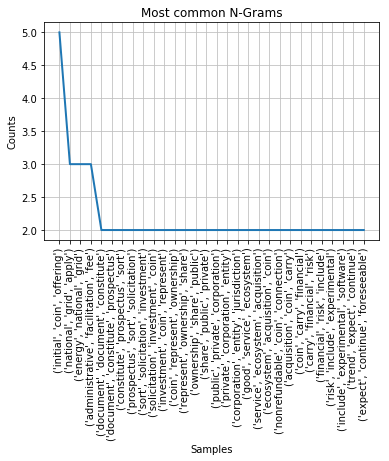

In [25]:
plt_ngrams = ir.visualize_ngrams(tokens, n=3)

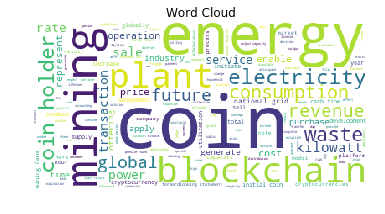

In [26]:
plt_wordcloud = ir.visualize_word_cloud(dataset.corpora_test_whole,protocol)

In [27]:
protocol = "adcoin"

In [28]:
tokens = ir.prepare_data(dataset.corpora_test_whole,protocol)

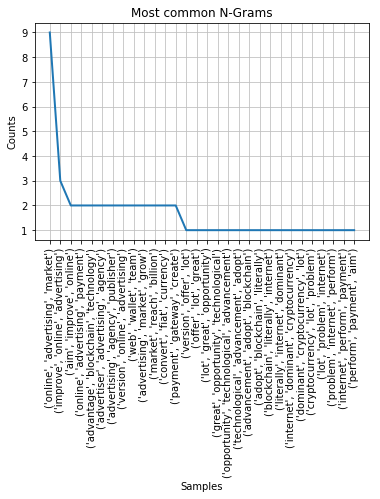

In [29]:
plt_ngrams = ir.visualize_ngrams(tokens, n=3)

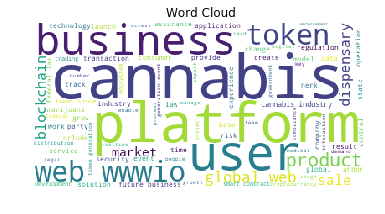

In [32]:
plt_wordcloud = ir.visualize_word_cloud(dataset.corpora_test_whole,protocol)

In [31]:
protocol = "budbo"

In [33]:
tokens = ir.prepare_data(dataset.corpora_test_whole,protocol)

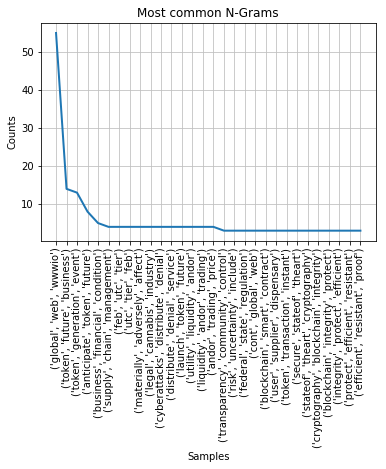

In [34]:
plt_ngrams = ir.visualize_ngrams(tokens, n=3)

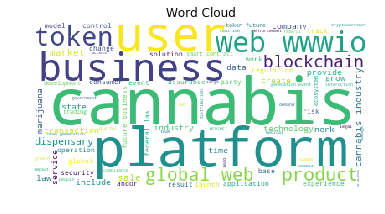

In [35]:
plt_wordcloud = ir.visualize_word_cloud(dataset.corpora_test_whole,protocol)

In [36]:
protocol = "oceanprotocol"

In [37]:
tokens = ir.prepare_data(dataset.corpora_test_whole,protocol)

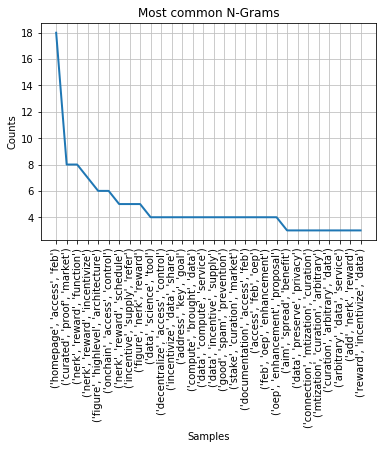

In [38]:
plt_ngrams = ir.visualize_ngrams(tokens, n=3)

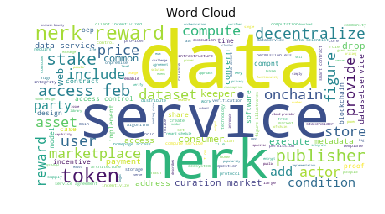

In [39]:
plt_wordcloud = ir.visualize_word_cloud(dataset.corpora_test_whole,protocol)

#### Document Clustering

In [ ]:
dc.prepare_data()

In [ ]:
dc.get_word2vec_model()

In [ ]:
dc.get_ap_model()

In [ ]:
dc.visualize_ap_clusters(protocol)

#### Text Extraction

In [ ]:
te.prepare_data()

In [ ]:
te.get_word2vec_model()

In [ ]:
te.visualize_ent(protocol)

In [ ]:
te.visualize_wordvec("marketing",protocol)

In [ ]:
te.visualize_pca(protocol)

#### Topic Modeling

In [ ]:
tm.prepare_data()

In [ ]:
tm.get_lda_model()

In [ ]:
tm.visualize_topics(protocol)

#### Text Classification

In [ ]:
tc.prepare_data()

In [ ]:
tc.get_tokenizer()

In [ ]:
tc.get_log_model()

In [ ]:
tc.get_nn_model()

In [ ]:
tc.visualize_log(protocol)

In [ ]:
tc.visualize_nn(protocol)